# Comparing Explainability Methods Under a White Box Model
This is a "fluorescent test," conducted under laboratory conditions with fluorescent lighting. In this test, we will generate synthetic data with known dynamics for the response variable. Next, we will calculate global explanations using various explainability methods and compare them against the ground truth.

In [13]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression

from explainer_comparison.ExplainerFactory import ExplainerFactory
from explainer_comparison.explainer_utilities import run_and_collect_explanations, permutation_feature_importance
from explainer_comparison.white_box_model.white_box import WhiteBoxRegressor
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np

## Generate a White-Box Model and Data

In [14]:
# model = WhiteBoxRegressor()
# df = model.generate_synthetic_data(n_samples=1000, with_y=True)
# X, y = df.drop(['y'], axis=1), df[['y']]

In [78]:
n_samples = 1000
n_features = 10
feature_columns = [f'f_{i+1}' for i in range(n_features)]

X, y = make_regression(n_samples=n_samples, n_features=n_features, n_informative=n_features, noise=0, random_state=42)
X = pd.DataFrame(X, columns=feature_columns)
y = pd.DataFrame(y, columns=['target'])

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [80]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

## Visualize Features and Target

<Axes: >

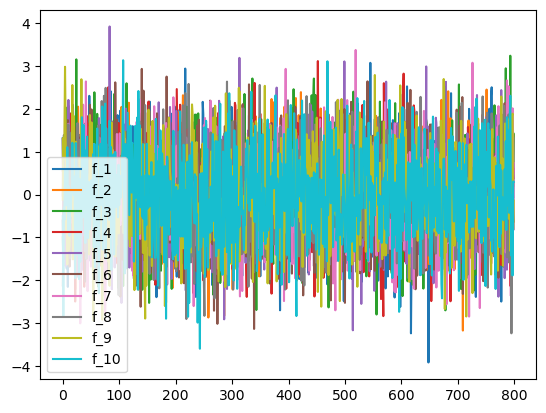

In [18]:
X_train.plot()

<Axes: >

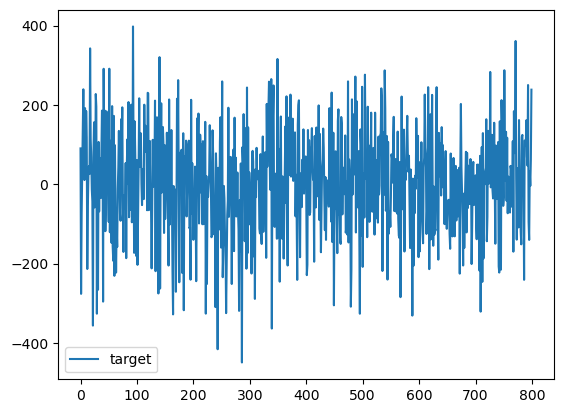

In [19]:
y_train.plot()

## Calculate SHAP and LIME explanation and Compare to Ground Truth

In [20]:
explainer_factory = ExplainerFactory(model, X_train, X_test, y_train, y_test)
results = run_and_collect_explanations(explainer_factory, X_train)
results['ground_truth'] = (X_train * model.coef_).mean()


 SHAP explanation created

 LIME explanation created


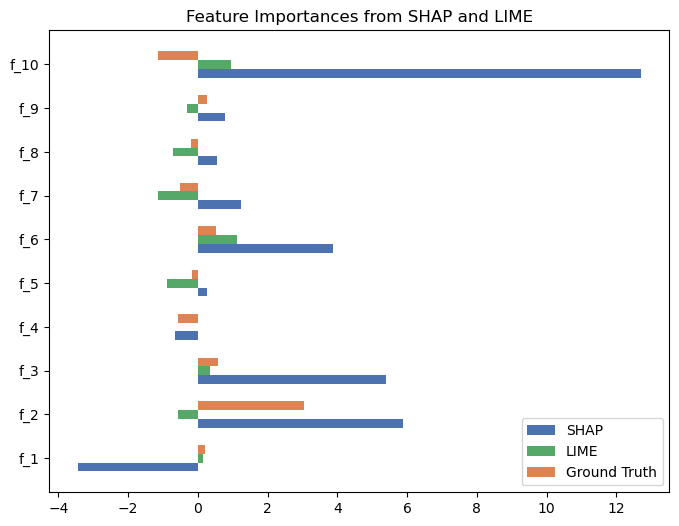

In [21]:
colors = sns.color_palette("deep")
plt.figure(figsize=(8, 6))

bar_positions = np.arange(len(results))  # Positions of the bars
bar_width = 0.2  # Adjust bar width to fit all bars

# Plotting the bars with adjusted positions
plt.barh(bar_positions - bar_width, results['SHAP Value'], height=bar_width, label='SHAP', color=colors[0])  # SHAP values
plt.barh(bar_positions, results['LIME Value'], height=bar_width, label='LIME', color=colors[2])  # LIME values
plt.barh(bar_positions + bar_width, results['ground_truth'], height=bar_width, label='Ground Truth', color=colors[1])  # Ground Truth values

plt.yticks(bar_positions, results.index)  #labels

plt.title('Feature Importances from SHAP and LIME')
plt.legend()
plt.show()

## Calculate permutation feature importance

In [22]:
feature_importances = permutation_feature_importance(model, X_test, y_test, metric='mse', random_state=42)

feature_importances_df = pd.DataFrame.from_dict(feature_importances, orient='index', columns=['importance'])
feature_importances_df = feature_importances_df.sort_values(by='importance', ascending=False)

feature_importances_df

,importance
f_5,-70.464934
f_8,-92.970425
f_4,-162.008498
f_9,-253.406676
f_7,-1580.369259
f_1,-2306.970366
f_3,-2379.803384
f_6,-7784.567787
f_2,-10488.564920
f_10,-11546.182891


In [152]:
import matplotlib.pyplot as plt

def plot_results(df):

    max_importance = df['importance'].max()
    std_importance = df['importance'].std()

    # Apply z-score normalization to the 'importance' column
    df['importance'] = (df['importance'] - max_importance) / std_importance

    fig, ax = plt.subplots(figsize=(12, 6))

    df.plot(kind='bar', ax=ax)
    ax.set_ylabel('Value')
    ax.set_xlabel('Feature')
    ax.set_title('SHAP, LIME, and Importance Values for Features')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_mse(shap_mse_values, lime_mse_values):
    # Plot the MSE values
    plt.figure(figsize=(10, 6))
    plt.plot(shap_mse_values, label='SHAP MSE')
    plt.plot(lime_mse_values, label='LIME MSE')
    plt.xlabel('Iteration')
    plt.ylabel('MSE')
    plt.title('Stability of SHAP and LIME Values')
    plt.legend()
    plt.grid(True)
    plt.show()

## Evaluate the consistency of SHAP and LIME

In [149]:
from sklearn.metrics import mean_squared_error

def evaluate_explainers(model, X_data, y_data, metric='mse', threshold=0.2, random_state=None):
    # Copy the data to avoid modifying the original
    current_X = X_data.copy()
    current_y = y_data.copy()
    current_model = model

    # Get the list of column names
    columns = X_data.columns.tolist()
    n = len(columns)
    remaining_features = n * threshold

    # Initialize variables to store SHAP and LIME MSE values
    shap_values_prev = None
    lime_values_prev = None
    shap_mse_values = []
    lime_mse_values = []

    # Loop until the number of features is reduced to the desired threshold
    while len(columns) > remaining_features:
        # Get SHAP and LIME values
        explainer_factory = ExplainerFactory(current_model, X_train=current_X, y_train=current_y)
        shap_lime_importance = run_and_collect_explanations(explainer_factory, current_X)
        shap_values = shap_lime_importance['SHAP Value']
        lime_values = shap_lime_importance['LIME Value']

        # Calculate MSE if this is not the first iteration
        if shap_values_prev is not None:
            shap_mse = mean_squared_error(shap_values_prev, shap_values)
            lime_mse = mean_squared_error(lime_values_prev, lime_values)
            shap_mse_values.append(shap_mse)
            lime_mse_values.append(lime_mse)

        # Update previous values for the next iteration
        shap_values_prev = shap_values.copy()
        lime_values_prev = lime_values.copy()

        # Calculate permutation feature importance
        feature_importances_dict = permutation_feature_importance(current_model, current_X, current_y, metric, random_state)
        feature_importances_df = pd.DataFrame.from_dict(feature_importances_dict, orient='index', columns=['importance'])

        # Find the least important feature
        sorted_feature_importances = feature_importances_df.sort_values(by='importance', ascending=True, key=abs)
        least_important_feature = sorted_feature_importances.index[0]

        # Print progress and results
        i = n - len(columns) + 1
        print(f'\n {i} features eliminated. Now the least_important_feature is ', least_important_feature)
        results = pd.concat([shap_lime_importance, feature_importances_df], axis=1)
        print(results)
        plot_results(results)

        # Drop the least important feature
        current_X = current_X.drop(columns=[least_important_feature])
        columns.remove(least_important_feature)

        # Remove the corresponding row from previous values
        shap_values_prev = shap_values_prev.drop(index=[least_important_feature])
        lime_values_prev = lime_values_prev.drop(index=[least_important_feature])

        # Retrain the model with the reduced feature set
        current_model = LinearRegression()
        current_model.fit(current_X, current_y)

    return shap_mse_values, lime_mse_values



 SHAP explanation created

 LIME explanation created

 1 features eliminated. Now the least_important_feature is  f_5
      SHAP Value  LIME Value    importance
f_1     4.505649    1.120868  -2563.696140
f_2    -6.603986   -0.277680 -10524.818482
f_3    -4.589519   -0.023777  -2356.156343
f_4    -0.442141   -0.690895   -179.584819
f_5     0.466635    0.957762    -63.019102
f_6     4.308876    1.313923  -7412.041598
f_7    -2.615803   -1.121062  -1571.204537
f_8    -1.039163    1.261396    -95.120109
f_9    -0.608533   -0.273379   -250.588631
f_10   -2.861167   -0.787715 -11079.394812


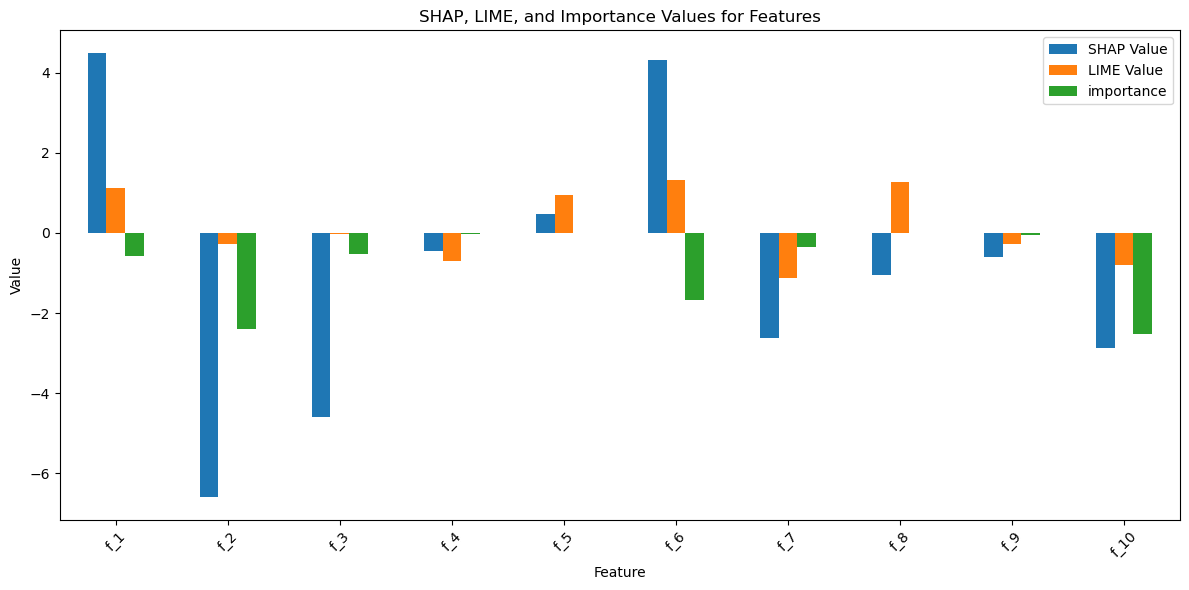


 SHAP explanation created

 LIME explanation created

 2 features eliminated. Now the least_important_feature is  f_8
      SHAP Value  LIME Value    importance
f_1     4.554546   -0.987542  -2713.320969
f_2    -6.605014   -0.533732 -10922.912497
f_3    -4.557237   -1.673882  -2550.919330
f_4    -0.447909   -1.239891   -189.976312
f_6     4.311435    1.005056  -7122.230490
f_7    -2.647601    1.089198  -1790.741365
f_8    -1.134789   -0.979974    -86.847918
f_9    -0.617405   -0.751880   -240.847232
f_10   -2.846813    0.015588 -11416.682864


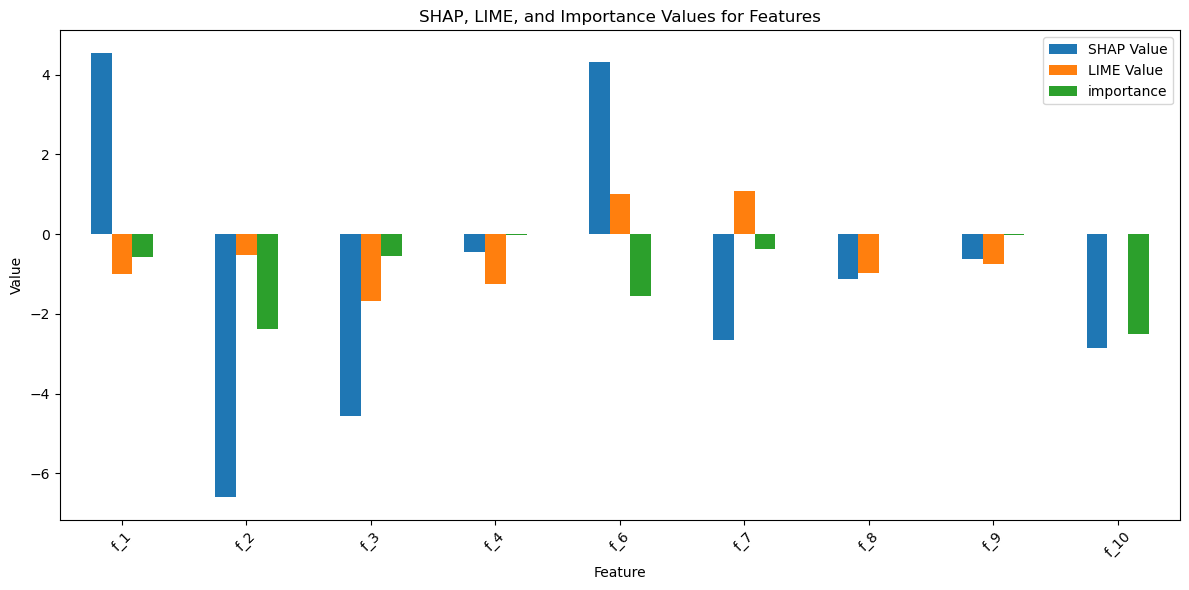


 SHAP explanation created

 LIME explanation created

 3 features eliminated. Now the least_important_feature is  f_4
      SHAP Value  LIME Value    importance
f_1     4.585615   -1.034777  -2203.293330
f_2    -6.641445   -0.414648 -10735.987311
f_3    -4.487166    0.172412  -2785.538945
f_4    -0.414198    0.004782   -189.758027
f_6     4.366814    1.253455  -7927.910643
f_7    -2.673135    0.342686  -1734.181378
f_9    -0.618766    0.549763   -222.318653
f_10   -2.851152   -1.879497 -11588.343765


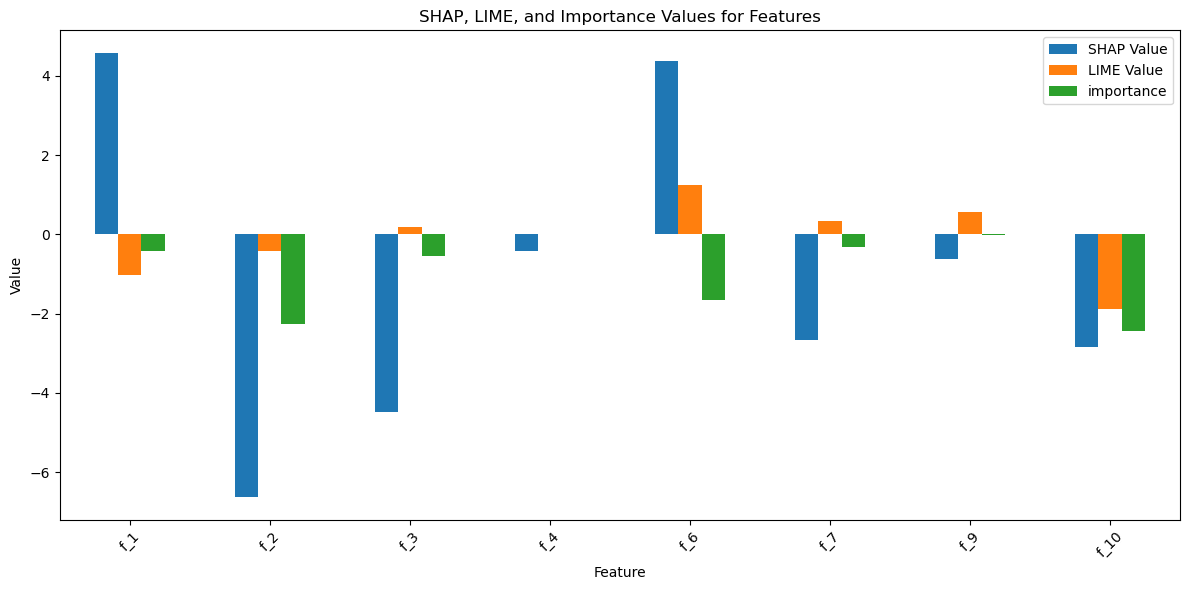


 SHAP explanation created

 LIME explanation created

 4 features eliminated. Now the least_important_feature is  f_9
      SHAP Value  LIME Value    importance
f_1     4.691474    0.818615  -2246.065082
f_2    -6.683157   -0.031800 -10631.579813
f_3    -4.430343    0.138767  -2279.299436
f_6     4.352758   -0.156697  -7405.093144
f_7    -2.732003    1.444697  -1864.589931
f_9    -0.638220   -0.540843   -276.309131
f_10   -2.892419    0.534881 -10898.545250


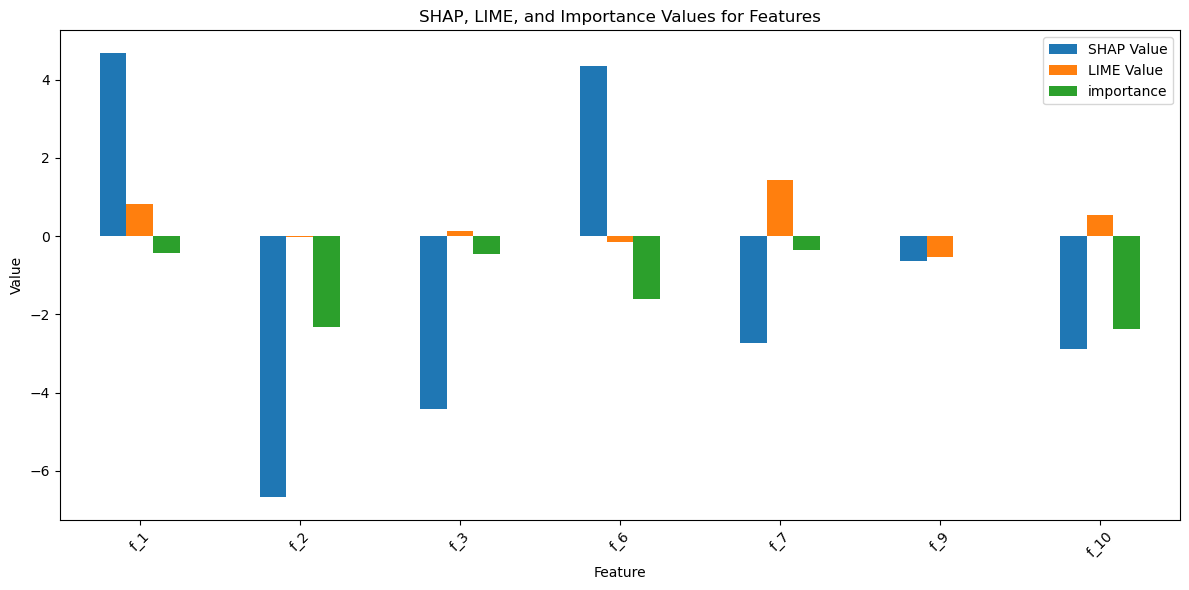


 SHAP explanation created

 LIME explanation created

 5 features eliminated. Now the least_important_feature is  f_7
      SHAP Value  LIME Value    importance
f_1     4.769912   -0.237454  -2777.172189
f_2    -6.617850   -0.362268 -11743.528415
f_3    -4.411594   -0.578864  -2453.587817
f_6     4.296555    0.156745  -7261.461722
f_7    -2.888803   -0.255189  -2052.914389
f_10   -2.894356   -0.414844 -11241.703174


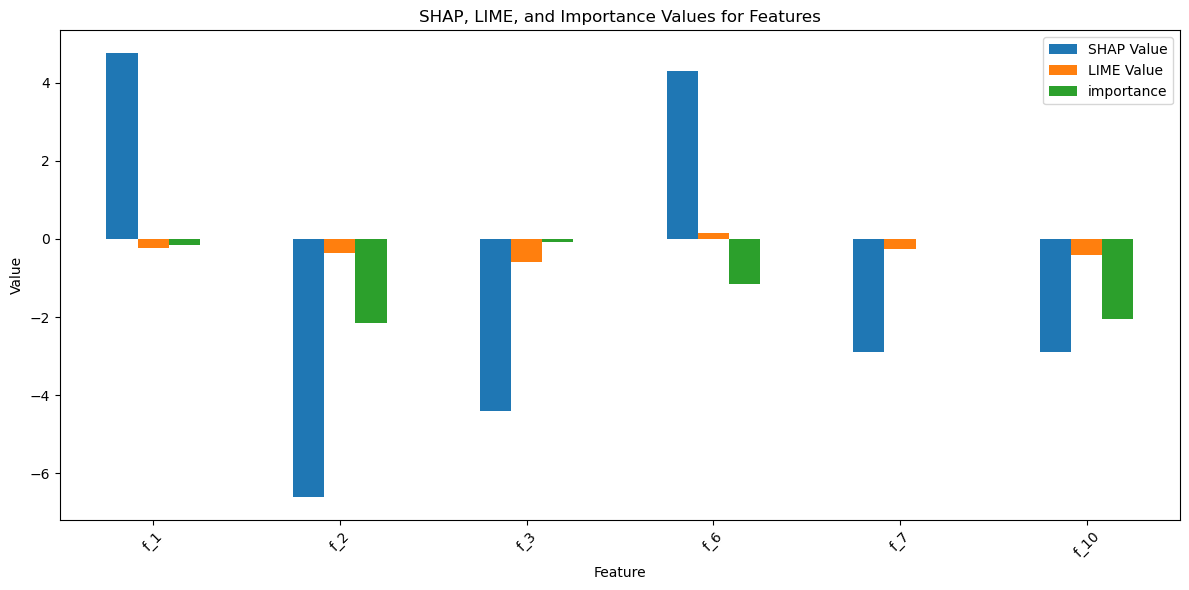


 SHAP explanation created

 LIME explanation created

 6 features eliminated. Now the least_important_feature is  f_3
      SHAP Value  LIME Value    importance
f_1     4.540490    0.629620  -2319.141459
f_2    -6.897446   -1.103058 -10403.446535
f_3    -4.332508   -1.622103  -2231.435889
f_6     4.302747    1.105187  -7004.104720
f_10   -2.701048   -0.897103 -10692.962480


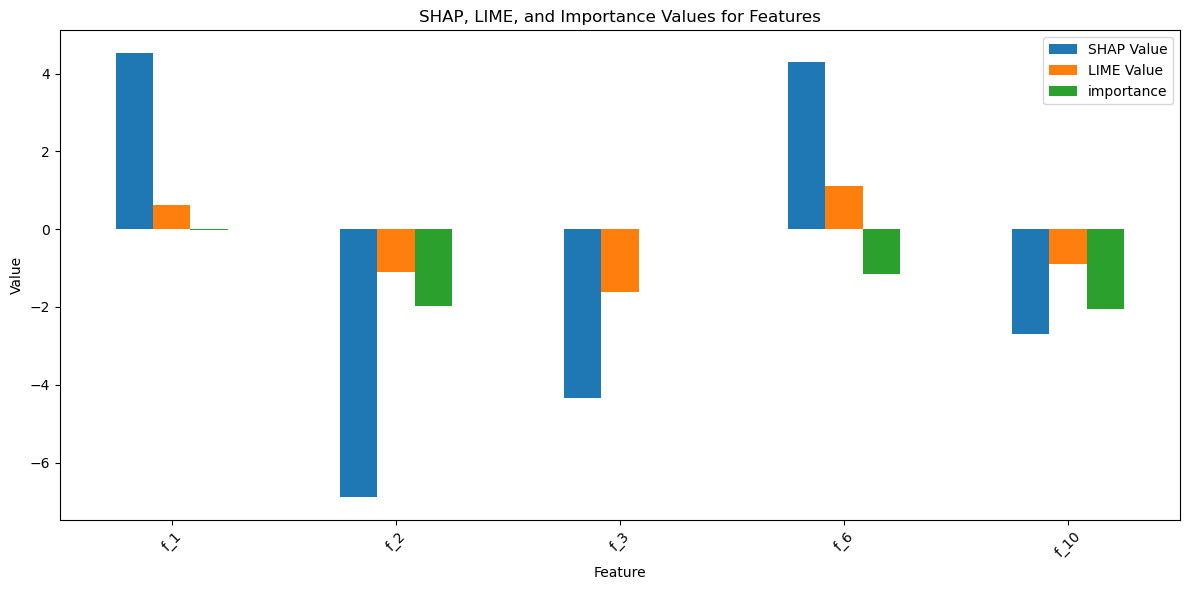


 SHAP explanation created

 LIME explanation created

 7 features eliminated. Now the least_important_feature is  f_1
      SHAP Value  LIME Value    importance
f_1     4.538450    1.233603  -2642.346922
f_2    -7.087654   -0.666737 -10394.519236
f_6     4.283449    0.625239  -7750.817123
f_10   -2.610469    0.018535  -9259.310212


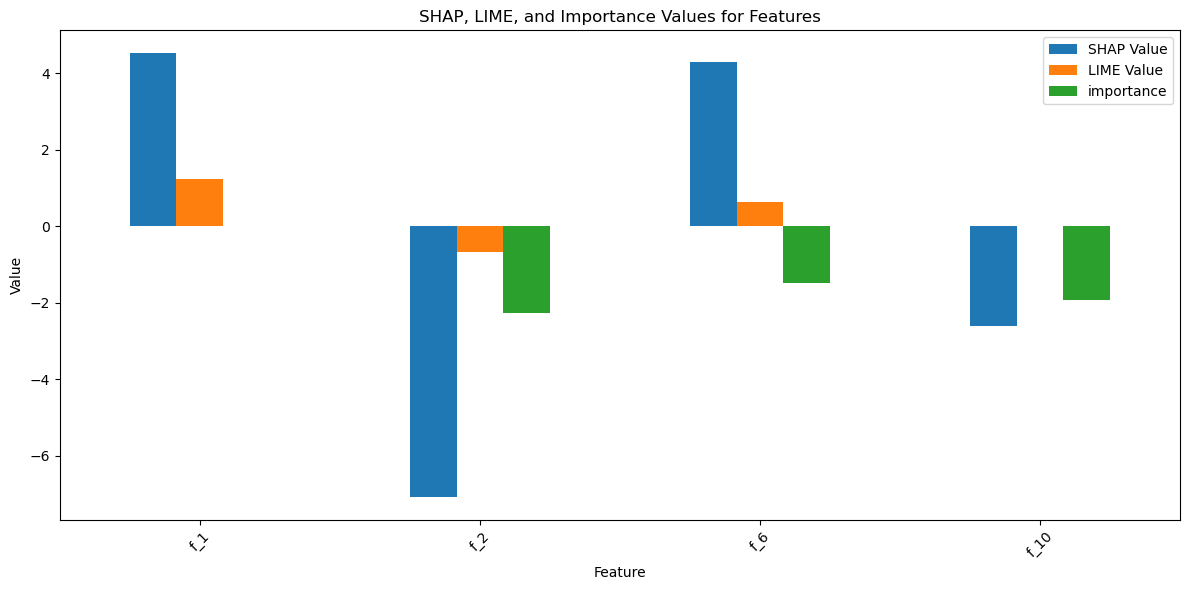

In [150]:
shap_mse_values, lime_mse_values = evaluate_explainers(model, X_test, y_test, metric='mse', threshold=0.3, random_state=42)


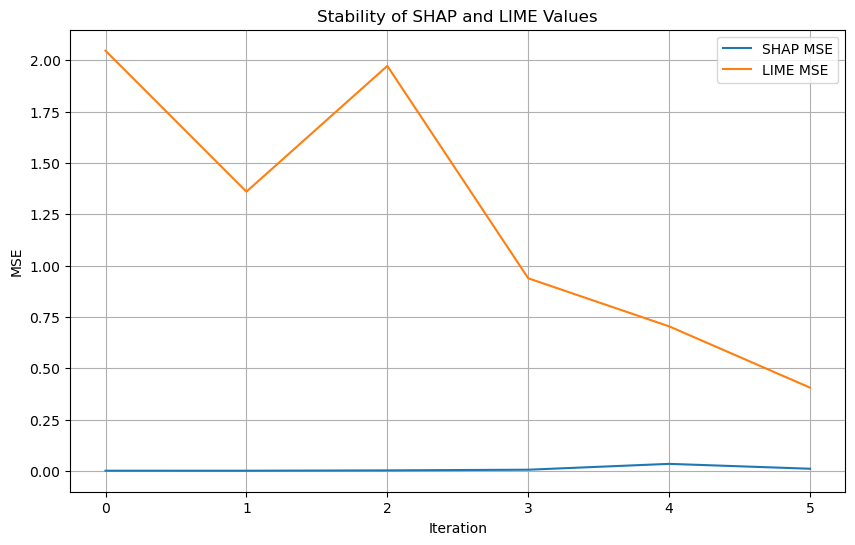

In [153]:
plot_mse(shap_mse_values, lime_mse_values)
